In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sympy as sp
from scipy.optimize import minimize, Bounds
sns.set(style="darkgrid")
sns.set_context("paper")
from itertools import permutations
from itertools import combinations 
from scipy.special import factorial

from sympy import init_printing
from sympy.abc import k, m, n, x
init_printing()

In [2]:
p, c1, c2, M_i, m_i = sp.symbols('p c1 c2 M_i m_i')
e = sp.abc.epsilon

## Single term log likelyhood for Multinomial distro 

In [3]:
L = M_i*sp.log(p*(1 - 3*e) + (1-p)*e) + m_i*sp.log((1-p)*(1-3*e)+p*e) + (c1 + c2)*sp.log(e)
L

## Find $p$ s.t. log likelyhood is  maximized 

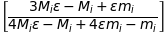

In [4]:
# differentiate w.r.t. p
dL = sp.diff(L,p)
# equate to zero and solve for p
sol = sp.solve(dL, p)
sol

##  Algebraic solution for $\epsilon$ is not tracktable

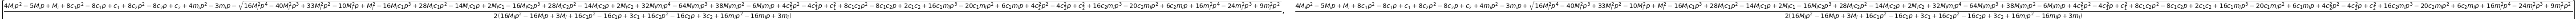

In [ ]:
# differentiate w.r.t. epsilon
dL = sp.diff(L,e)
# equate to zero and solve for epsilon
sol = sp.solve(dL, e)
sol

## Alternative hypothesis categorical distribution

In [ ]:
# from scipy.misc import factorial

def multinom(p, e, major, minor, er1, er2, ignoreCoeff=False):
    n = major + minor + er1 + er2
    multinom_coef = factorial(n)/(factorial(major)*factorial(minor)*factorial(er1+er2))
#     multinom_coef = factorial(n)/(factorial(major)*factorial(minor)*factorial(er1)*factorial(er2))

    p_major = np.power(p*(1-3*e) + (1-p)*e, major)
    p_minor = np.power((1-p)*(1-3*e) + p*e, minor)
    p_error = np.power(e,er1+er2)
    
    if ignoreCoeff:
        return p_major*p_minor*p_error
    else:
        return p_major*p_minor*p_error*multinom_coef

## Sample dataset from alternative hypothesis distribution

In [ ]:
""" In this cell I sample points from the alternative hypothesis distribution
with some fixed parameters p and epsilon """

sp.init_printing(pretty_print=False)

p = 0.75
e = 0.001

# Generate sample space
cat_5_perm = set(permutations([5,0,0,0]))
cat_4_1_perm = set(permutations([4, 1, 0, 0]))
cat_3_2_perm = set(permutations([3, 2, 0, 0]))
cat_3_1_1_perm = set(permutations([3, 1, 1, 0]))
cat_2_2_1_perm = set(permutations([2, 2, 1, 0]))
cat_2_1_1_1_perm = set(permutations([2, 1, 1, 1]))

# take all sets
all_perms = [cat_5_perm, cat_4_1_perm, cat_3_2_perm, cat_3_1_1_perm, cat_2_2_1_perm, cat_2_1_1_1_perm]


# iterate through each set and put all permutations into a list
categorical_combinations = []
for perm in all_perms:
    for item in perm:
        categorical_combinations.append(item)
        
# each integer represents a categorical combination 
ints = np.arange(0,len(categorical_combinations))    

# build the discrete distribution for each data point
distro = []
for category in categorical_combinations:
    distro.append(multinom(p, e, category[0], category[1], category[2], category[3]))

# because of non zero epsilon the total probab is not 1, do normalization
distro = np.array(distro)
print('the total probability of all data points before normalization:', np.sum(distro))

distro = distro/np.sum(distro)

# generate data set
data = []
num_data_points = 200

for i in range(0,num_data_points):
    data.append(np.random.choice(a=ints, p=distro))

# map integers to categorical combinations
dataset = []
for num in data:
    lst = list(categorical_combinations[num])
    dataset.append(lst)
dataset = np.array(dataset)


the total probability of all data points before normalization: 0.999990019985004


## Do numerical optimization to estimate $\epsilon$ and $p$

### Define objective functions

In [ ]:
""" Define objective functions """
# objective function for error
def obj_func_err(er, p, M, m, c_1, c_2):
    res = -(M*np.log(p*(1 - 3*er) + (1-p)*er) + m*np.log((1-p)*(1-3*er)+p*er) + (c_1 + c_2)*np.log(er))
    return np.sum(res)

# objective function for p
def obj_func_p(p, er, M, m, c_1, c_2):
    res = -(M*np.log(p*(1 - 3*er) + (1-p)*er) + m*np.log((1-p)*(1-3*er)+p*er) + (c_1 + c_2)*np.log(er))
    return np.sum(res)


# iterative optimization
def optimize(num_iter, init_p, init_err, M_i, m_i, c_1, c_2):
    estimated_err = [init_err]
    estimated_p = [init_p]
    
    p_bound = Bounds(0.5, 0.9)
    e_bound = Bounds(1e-100, 0.2)
    opts = {'disp':False, 'gtol':1e-100}
    for i in range(num_iter):
        # estimate proportion of a major strain given estimated error
        res_p = minimize(obj_func_p, [initial_p], args = (estimated_err[i], M_i, m_i, c_1, c_2), method='TNC',bounds=p_bound, options=opts)
        estimated_p.append(res_p.x[0])
        # estimate error given proportion
        res_err = minimize(obj_func_err, [init_err], args = (estimated_p[i], M_i, m_i, c_1, c_2), method='TNC', bounds=e_bound, options=opts)
        estimated_err.append(res_err.x[0])
    return [estimated_p, estimated_err]

### Run optimization on a sampled dataset

data points generated: 200
actual error 0.001 , estimated error:  1e-100
actual proportion 0.75 , estimated proportion of Major:  0.7619999979927098
abs error for epsilon 0.001


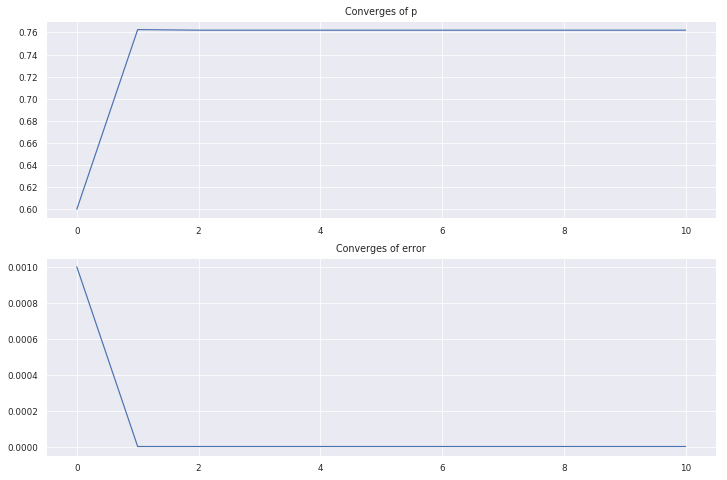

In [ ]:
initial_err = 0.001
initial_p = 0.6


M_i = dataset[:,0]
m_i = dataset[:,1]
c_1 = dataset[:,2]
c_2 = dataset[:,3]
num_iter = 10

estimated_p, estimated_err = optimize(num_iter, initial_p, initial_err, M_i, m_i, c_1, c_2)

def plotConvergence(num_data_points, estimated_p, estimated_err, p, e):
    print('data points generated:',num_data_points)
    print('actual error', e, ', estimated error: ', estimated_err[-1])
    print('actual proportion',p, ', estimated proportion of Major: ', estimated_p[-1])
    print('abs error for epsilon', abs(e - estimated_err[-1]))
    plt.figure(figsize=(12,8))
    plt.subplot(211)
    plt.title('Converges of p')
    plt.plot(np.arange(len(estimated_p)),estimated_p)

    plt.subplot(212)
    plt.title('Converges of error')
    plt.plot(np.arange(len(estimated_err)), estimated_err)
    
plotConvergence(num_data_points, estimated_p, estimated_err, p, e)

##  Run likelihood ratio

we are under hypothesis 1
### null hypo error estimate: 0.005802320928371348
### alt hypo error estimate: 1e-100
### alt hypo p estimate: 0.9


### null hypothesis likelihood: -178.08154280804837
### alter hypothesis likelihood: -239.25013182868895
### log ratio: -122.33717804128116 ratio: 3.674351309988198e+26 treshold: 599.1464547107979
### Result: single strain
data points generated: 20
actual error -1 , estimated error:  1e-100
actual proportion 0.982593037214886 , estimated proportion of Major:  0.9
abs error for epsilon 1.0


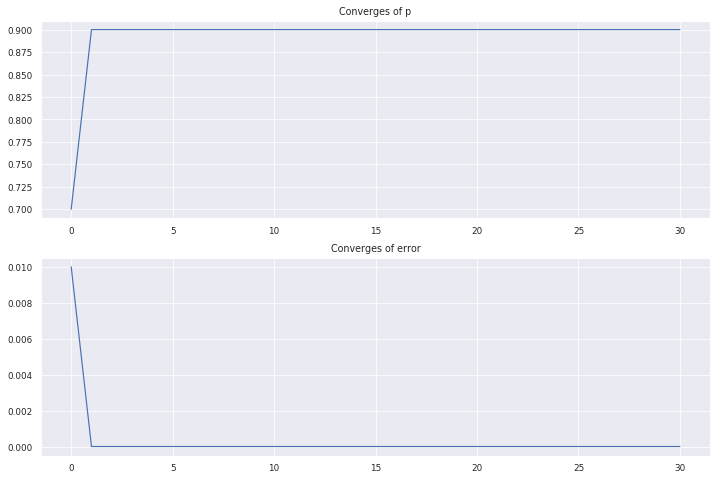

In [ ]:
hypo = 1
print('we are under hypothesis', hypo)
# one strain
num_points = 20

if hypo == 1:
    major = np.random.randint(75,90,num_points, int)
    minor = np.random.randint(1,3, num_points, int)
    # count other chars
    error1 = np.zeros(num_points)
    error2 = np.zeros(num_points)
    errors =  minor + error1 + error2
    
# two strains
elif hypo == 2:
    major = np.random.randint(75,90,num_points, int)
    minor = np.random.randint(20,30, num_points, int)
    error1 = np.zeros(num_points)
    error2 = np.zeros(num_points)

# one strain
elif hypo == 3:
    major = np.array([80, 85, 89, 99, 98, 100, 90, 101, 96, 80, 70, 80])   # count of Major
    minor = np.array([20, 20, 10, 5, 2, 1, 1, 1, 1, 1, 1, 0])      # count of Minor
    # count other chars
    error1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,1])
    error2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    
local_n = major + minor + error1 + error2
actual_major_prop = np.sum(major)/np.sum(local_n)


# estimate error for null hypo
null_err = np.sum(local_n - major) / (3*np.sum(local_n))
print('### null hypo error estimate:', null_err)

# likelihood null hypo
errors = error1 + error2 + minor
null_hypo = np.sum(np.log(np.power(null_err, errors))) + np.sum(np.log(np.power((1 - 3*null_err), major)))

# estimate error and probability of major for alternative hypo
estimated_p, estimated_err = optimize(30, 0.7, 0.01, major, minor, error1, error2)
alt_p = estimated_p[-1]
alt_err = estimated_err[-1]
print('### alt hypo error estimate:', alt_err)
print('### alt hypo p estimate:', alt_p)
print('\n')


# compute alternative hypothesis likelihood
alt_hypo = np.sum(np.log(multinom(alt_p, alt_err, major, minor, error1, error2, True)))
print('### null hypothesis likelihood:', null_hypo)
print('### alter hypothesis likelihood:', alt_hypo)

# Pearson chi2 test
from scipy.stats import chi2
# we test under null hypothesis
df = 2
alpha = 0.95
critical = chi2.ppf(alpha, df, loc=0, scale=100)
log_ratio = -2*(null_hypo - alt_hypo)
ratio = np.exp(-log_ratio/2)
tresh = critical
print('### log ratio:', log_ratio, 'ratio:', ratio, 'treshold:', tresh)
if  log_ratio < tresh:
    print('### Result: single strain')
else:
    print('### Result: two strains')

plotConvergence(len(major), estimated_p, estimated_err, actual_major_prop, -1)

### Chi2 distro

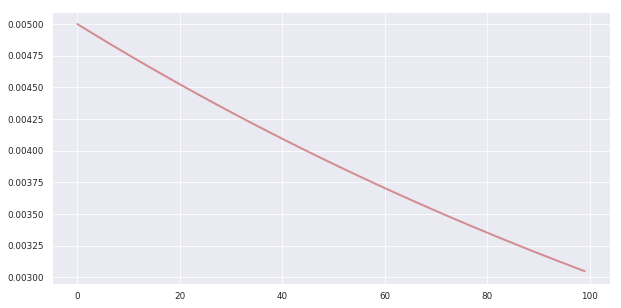

In [ ]:
plt.figure(figsize=(10,5))
deg_f = 2
x = np.arange(100)
plt.plot(x, chi2.pdf(x, deg_f, scale=100, loc= 0), 'r-', lw=2, alpha=0.6, label='chi2 pdf')
plt.show()

## split error based on SNP

In [ ]:
%cd /home/user1/Documents/lab/DrugResistance/splitStrains/
%pwd
%run graphSplitError.py

/home/user1/Documents/lab/DrugResistance/splitStrains
number of intoruced SNPs by alt_ref: 80 . Make sure to check this value.
# of differences between alt ref and original ref: 80
# of differences between consensus and alt ref: 114
# of introduced SNPs that were not resolved by splitStrains.py: 48
# of differences between alt ref and original ref: 80
# of differences between consensus and alt ref: 54
# of introduced SNPs that were not resolved by splitStrains.py: 12
# of differences between alt ref and original ref: 80
# of differences between consensus and alt ref: 2
# of introduced SNPs that were not resolved by splitStrains.py: 1
# of differences between alt ref and original ref: 80
# of differences between consensus and alt ref: 1
# of introduced SNPs that were not resolved by splitStrains.py: 1
# of differences between alt ref and original ref: 80
# of differences between consensus and alt ref: 1
# of introduced SNPs that were not resolved by splitStrains.py: 1
# of differences b